In [2]:
import pydpmd as dp
from pydpmd.utils import join_systems
from system_building_resources import *
import numpy as np
import os
import matplotlib.pyplot as plt
from pydpmd.plot import draw_particles_frame, create_animation, downsample, draw_circle
import subprocess

In [3]:
rb = dp.data.load('/home/mmccraw/dev/data/12-01-25/grace-data/rb-small/mu-0.5-nv-19/jamming_9/', location=['final', 'init'], load_trajectory=True)
rb.calculate_mu_eff()
rb = split_systems(rb)[0]

In [4]:
from pydpmd.data import DeformableBumpy

center_dist = np.linalg.norm(rb.vertex_pos - rb.pos[rb.vertex_particle_id], axis=1)
core_mask = center_dist == 0

db = DeformableBumpy()
db.allocate_particles(rb.n_particles())
db.allocate_systems(rb.n_systems())
db.allocate_vertices(np.sum(~core_mask))
db.n_vertices_per_particle = np.bincount(rb.vertex_particle_id[~core_mask]).astype(DT_INT)
db.system_size = rb.system_size.copy().astype(DT_INT)
db.system_offset = rb.system_offset.copy().astype(DT_INT)
db.vertex_system_size = np.add.reduceat(db.n_vertices_per_particle, db.system_offset[:-1]).astype(DT_INT)
db.vertex_system_id = rb.vertex_system_id[~core_mask].copy().astype(DT_INT)
db.system_id = rb.system_id.copy().astype(DT_INT)
db.set_ids()
db.validate()

db.pos = rb.pos.copy()
db.vertex_pos = rb.vertex_pos[~core_mask].copy()
db.box_size = rb.box_size.copy().astype(DT_FLOAT)
db.rad = rb.rad.copy().astype(DT_FLOAT)
db.vertex_rad = rb.vertex_rad[~core_mask].copy().astype(DT_FLOAT)
db.vertex_mass = rb.vertex_mass[~core_mask].copy().astype(DT_FLOAT)
db.e_interaction = rb.e_interaction.copy().astype(DT_FLOAT)

db.e_area = np.ones(rb.n_systems())
db.e_bend = np.ones(rb.n_systems())
db.e_length = np.ones(rb.n_systems())

db.set_preferred_geometry()

db.set_neighbor_method(NeighborMethod.Naive)
db.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(db, 0.3)

db.set_velocities(1e-4, np.random.randint(0, 1000000))
db.save('db')

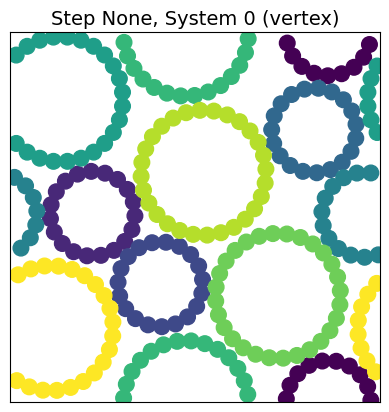

In [5]:
draw_particles_frame(None, plt.gca(), db, 0, True, 'vertex', 'viridis', None)

In [8]:
path = '/home/mmccraw/dev/analysis/fall-25/12/testing-dp/db'

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_deformable_bumpy_pbc_final"),
    path,
    path,
    str(1e3),
    str(1e0),
    str(1e-2)
], check=True)

Running for 1000 steps
Step 0


Kernel runtime error: an illegal memory access was encountered
  at /home/mmccraw/dev/dpmd/include/particles/base_poly_particle.hpp:597
  kernel: md::geo::scatter_order_kernel


CalledProcessError: Command '['/home/mmccraw/dev/dpmd/build/nve_deformable_bumpy_pbc_final', '/home/mmccraw/dev/analysis/fall-25/12/testing-dp/db', '/home/mmccraw/dev/analysis/fall-25/12/testing-dp/db', '1000.0', '1.0', '0.01']' died with <Signals.SIGABRT: 6>.

In [9]:
dynamics_data = dp.data.load(path, location=['final', 'init'], load_trajectory=True)

OSError: Unable to synchronously open file (truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048)

NameError: name 'dynamics_data' is not defined

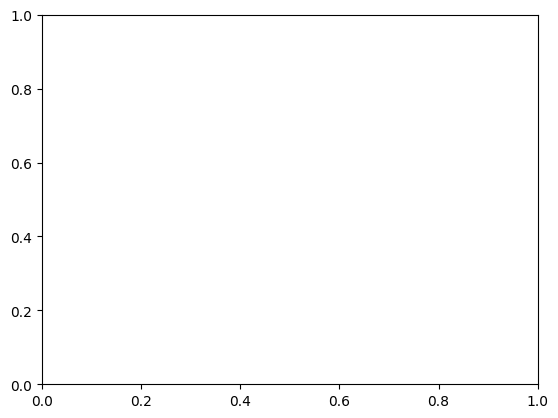

In [13]:
frame = 99
sid = 0
draw_particles_frame(frame, plt.gca(), dynamics_data, sid, True, 'vertex', 'viridis', 'trajectory')

f = dynamics_data.trajectory.vertex_force[frame, dynamics_data.system_offset[sid]:dynamics_data.system_offset[sid+1]]
box_size = dynamics_data.box_size[sid]
p = np.mod(dynamics_data.trajectory.vertex_pos[frame, dynamics_data.system_offset[sid]:dynamics_data.system_offset[sid+1]], box_size)
plt.quiver(p[:, 0], p[:, 1], f[:, 0], f[:, 1])

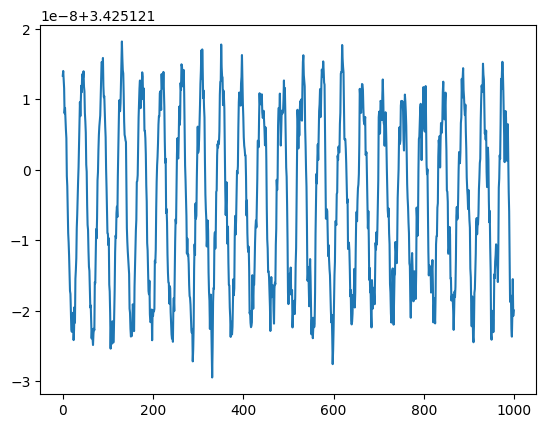

In [126]:
plt.plot(dynamics_data.trajectory.vertex_pos[:, 0, 0])

In [124]:
desired_frames = 100
steps_to_animate = downsample(dynamics_data, desired_frames)

output_path = "anim.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,
    bitrate=3000,
    data=dynamics_data,
    system_id=0,
    use_pbc=True,
    which='vertex',
    cmap_name='grey',
    id_scale=1.1
)

Creating animation:   4%|▍         | 4/100 [00:00<00:03, 30.44it/s]

Saving animation to anim.gif...


Creating animation: 101it [00:06, 15.88it/s]                        

Animation saved successfully!
